{'alphaA': '63.00756024563932', 'alphaA_prime': '1404.8308936091778', 'alphaR': '0.002304815059232311', 'alphaR_prime': '42.86431723884965', 'betaA': '53.94021160316451', 'betaR': '7.802151831109245', 'deltaMA': '30.8917655246071', 'deltaMR': '0.5335262779563781', 'deltaA': '1.0', 'deltaR': '0.2347943935064347', 'gammaA': '1.0', 'gammaR': '1.0', 'gammaC': '2.0091391416439097', 'thetaA': '38.37938935149368', 'thetaR': '114.5729873319275'}
Analysis of Time Series Data:
                                                                A  \
Frequency                                                0.048683   
Time per Cycle  [32.06409, 16.0321, 18.036100000000005, 16.031...   
Amplitude           [319.257, 1.68944, 1.52759, 1.51969, 1.51929]   

                                                      C  \
Frequency                                      0.046781   
Time per Cycle  [32.06408, 16.0321, 16.032100000000007]   
Amplitude          [489.081, 146.483, 144.516, 144.416]   

              

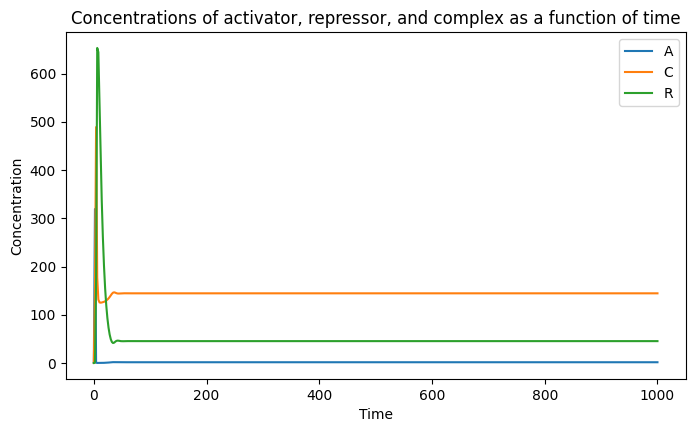

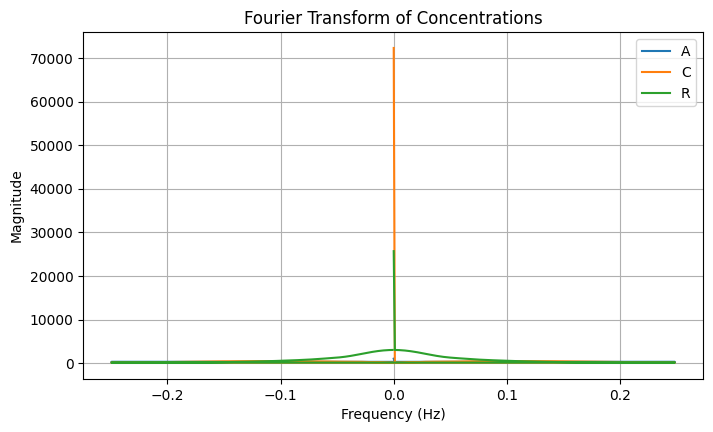


Top 10 Fourier components of species A:
   Frequency (Hz)    Magnitude
0       -0.027944   319.855912
1        0.031936   319.957129
2       -0.031936   319.957129
3        0.028942   319.990624
4       -0.028942   319.990624
5       -0.030938   320.036435
6        0.030938   320.036435
7        0.029940   320.049392
8       -0.029940   320.049392
9        0.000000  1061.619727

Top 10 Fourier components of species C:
   Frequency (Hz)     Magnitude
0       -0.103792    500.718077
1        0.107784    500.773664
2       -0.107784    500.773664
3       -0.104790    500.818005
4        0.104790    500.818005
5        0.106786    500.837798
6       -0.106786    500.837798
7       -0.105788    500.855039
8        0.105788    500.855039
9        0.000000  72279.161000

Top 10 Fourier components of species R:
   Frequency (Hz)     Magnitude
0       -0.004990   3025.136361
1       -0.003992   3037.074559
2        0.003992   3037.074559
3       -0.002994   3046.392264
4        0.002994   3046

In [2]:
import gillespy2
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft
from scipy.signal import find_peaks
import pandas as pd

# Parameters used in the provided model
parameters_used = {
    'alphaA': 50,
    'alphaA_prime': 500,
    'alphaR': 0.01,
    'alphaR_prime': 50,
    'betaA': 50,
    'betaR': 5,
    'deltaMA': 10,
    'deltaMR': 0.5,
    'deltaA': 1,
    'deltaR': 0.2,
    'gammaA': 1,
    'gammaR': 1,
    'gammaC': 2,
    'thetaA': 50,
    'thetaR': 100
}

# Function to generate random parameters based on normal distribution
def generate_random_parameters(parameters_used, num_samples=1, std_dev=0.2):
    random_parameters = {}
    for parameter, value in parameters_used.items():
        # Calculate mean and standard deviation for the normal distribution
        mean = np.log10(value)
        std = abs(std_dev * mean)
        
        random_samples = np.random.normal(mean, std, num_samples)
        
        # Ensure generated parameters are positive
        random_samples = np.clip(random_samples, a_min=np.log10(1e-10), a_max=None)
        
        # Convert back to linear scale and string format
        random_parameters[parameter] = str(10 ** random_samples[0])
    
    return random_parameters

random_parameters = generate_random_parameters(parameters_used)
print(random_parameters)

# Hysteresis model from Kut 2009/from Vilar 2002
def create_vilar_oscillator(alphaA, alphaA_prime, alphaR, alphaR_prime, betaA, betaR, deltaMA, deltaMR, deltaA, deltaR, gammaA, gammaR, gammaC, thetaA, thetaR):
    # Initialize Model
    model = gillespy2.Model(name="VilarOscillator")
    
    # Set System Volume
    model.volume = 1

    # Define Variables (GillesPy2.Species)
    Da = gillespy2.Species(name="Da", initial_value=1, mode="discrete")
    Da_prime = gillespy2.Species(name="Da_prime", initial_value=0, mode="discrete")
    Ma = gillespy2.Species(name="Ma", initial_value=0, mode="discrete")
    Dr = gillespy2.Species(name="Dr", initial_value=1, mode="discrete")
    Dr_prime = gillespy2.Species(name="Dr_prime", initial_value=0, mode="discrete")
    Mr = gillespy2.Species(name="Mr", initial_value=0, mode="discrete")
    C = gillespy2.Species(name="C", initial_value=0, mode="discrete")
    A = gillespy2.Species(name="A", initial_value=0, mode="discrete")
    R = gillespy2.Species(name="R", initial_value=0, mode="discrete")

    # Add Variables to Model
    model.add_species([Da, Da_prime, Ma, Dr, Dr_prime, Mr, C, A, R])

    # Define Parameters
    model.add_parameter([gillespy2.Parameter(name="alphaA", expression=str(alphaA)),
                         gillespy2.Parameter(name="alphaA_prime", expression=str(alphaA_prime)),
                         gillespy2.Parameter(name="alphaR", expression=str(alphaR)),
                         gillespy2.Parameter(name="alphaR_prime", expression=str(alphaR_prime)),
                         gillespy2.Parameter(name="betaA", expression=str(betaA)),
                         gillespy2.Parameter(name="betaR", expression=str(betaR)),
                         gillespy2.Parameter(name="deltaMA", expression=str(deltaMA)),
                         gillespy2.Parameter(name="deltaMR", expression=str(deltaMR)),
                         gillespy2.Parameter(name="deltaA", expression=str(deltaA)),
                         gillespy2.Parameter(name="deltaR", expression=str(deltaR)),
                         gillespy2.Parameter(name="gammaA", expression=str(gammaA)),
                         gillespy2.Parameter(name="gammaR", expression=str(gammaR)),
                         gillespy2.Parameter(name="gammaC", expression=str(gammaC)),
                         gillespy2.Parameter(name="thetaA", expression=str(thetaA)),
                         gillespy2.Parameter(name="thetaR", expression=str(thetaR))])

    # Define Reactions
    #bound and unbound of DA/DR
    r1 = gillespy2.Reaction(name="r1", reactants={'A': 1, 'Da': 1}, products={'Da_prime': 1}, rate="gammaA")
    r2 = gillespy2.Reaction(name="r2", reactants={'Da_prime': 1}, products={'A': 1, 'Da': 1}, rate="thetaA")
    r3 = gillespy2.Reaction(name="r3", reactants={'A': 1, 'Dr': 1}, products={'Dr_prime': 1}, rate="gammaR")
    r4 = gillespy2.Reaction(name="r4", reactants={'Dr_prime': 1}, products={'A': 1, 'Dr': 1}, rate="thetaR")
    #transcription
    r5 = gillespy2.Reaction(name="r5", reactants={'Da': 1}, products={'Da': 1, 'Ma': 1}, rate="alphaA")
    r6 = gillespy2.Reaction(name="r6", reactants={'Da_prime': 1}, products={'Da_prime': 1, 'Ma': 1}, rate="alphaA_prime")
    r7 = gillespy2.Reaction(name="r7", reactants={'Dr': 1}, products={'Dr': 1, 'Mr': 1}, rate="alphaR")
    r8 = gillespy2.Reaction(name="r8", reactants={'Dr_prime': 1}, products={'Dr_prime': 1, 'Mr': 1}, rate="alphaR_prime")
    #translation
    r9 = gillespy2.Reaction(name="r9", reactants={'Ma': 1}, products={'A': 1, 'Ma': 1}, rate="betaA")
    r10 = gillespy2.Reaction(name="r10", reactants={'Mr': 1}, products={'Mr': 1, 'R': 1}, rate="betaR")    
    #complex formation
    r11 = gillespy2.Reaction(name="r11", reactants={'A': 1, 'R': 1}, products={'C': 1}, rate="gammaC")
    #degradation
    r12 = gillespy2.Reaction(name="r12", reactants={'A': 1}, products={}, rate="deltaA")
    r13 = gillespy2.Reaction(name="r13", reactants={'C': 1}, products={'R': 1}, rate="deltaA")
    r14 = gillespy2.Reaction(name="r14", reactants={'R': 1}, products={}, rate="deltaR")
    r15 = gillespy2.Reaction(name="r15", reactants={'Ma': 1}, products={}, rate="deltaMA")    
    r16 = gillespy2.Reaction(name="r16", reactants={'Mr': 1}, products={}, rate="deltaMR")

    # Add Reactions to Model
    model.add_reaction([r1, r2, r3, r4, r5, r6, r7, r8, r9, r10, r11, r12, r13, r14, r15, r16])

    # Define Timespan
    tspan = gillespy2.TimeSpan.linspace(t=1000, num_points=500)
    
    # Set Model Timespan
    model.timespan(tspan)
    return model

# Generate random parameters
random_parameters = generate_random_parameters(parameters_used)

# Create the model using random parameters
model = create_vilar_oscillator(**random_parameters)
ode_results = model.run(algorithm="ODE")

species_of_interest = ['A', 'C', 'R']

def analyze_time_series(ode_results):
    analysis_data = {}
    for species in species_of_interest:
        # Extract time series data
        time_series = ode_results[0]['time']
        concentration_series = ode_results[0][species]
        
        # Find peaks in concentration series
        peaks, _ = find_peaks(concentration_series, height=0)
        
        # Compute frequency
        period_lengths = np.diff(time_series[peaks])
        frequency = 1 / np.mean(period_lengths)
        
        # Compute time for each cycle
        cycle_times = np.diff(time_series[peaks])
        
        # Compute amplitude
        amplitudes = concentration_series[peaks]
        
        # Store analysis data
        analysis_data[species] = {
            'Frequency': frequency,
            'Time per Cycle': cycle_times,
            'Amplitude': amplitudes
        }
    
    # Convert analysis data to DataFrame
    analysis_df = pd.DataFrame(analysis_data)
    return analysis_df

# Analyze time series data
analysis_df = analyze_time_series(ode_results)

# Print analysis results
print("Analysis of Time Series Data:")
print(analysis_df)
plt.figure(figsize=(8, 4.5))
plt.title("Concentrations of activator, repressor, and complex as a function of time")
plt.xlabel('Time')
plt.ylabel('Concentration')

species_of_interest = ['A', 'C', 'R']

for species in species_of_interest:
    plt.plot(ode_results[0]['time'], ode_results[0][species], label=species)

plt.legend()
plt.show()


# Perform Fourier transformation for A, C, and R concentrations and print the top 10 Fourier components
species_data = {}

plt.figure(figsize=(8, 4.5))  # Create the figure outside the loop

for species in species_of_interest:
    # Compute the FFT
    fft_data = fft(ode_results[0][species])
    
    # Compute the corresponding frequencies
    freqs = np.fft.fftfreq(len(ode_results[0][species]), ode_results[0]['time'][1] - ode_results[0]['time'][0])

    # Find indices of top 10 frequencies
    top_indices = np.argsort(np.abs(fft_data))[-10:]
    
    # Get top 10 frequencies and their corresponding magnitudes
    top_freqs = freqs[top_indices]
    top_fft_data = np.abs(fft_data[top_indices])

    # Plot the Fourier transform for each species
    plt.plot(freqs, np.abs(fft_data), label=species)

    # Store data for printing top 10 Fourier components
    species_data[species] = {'Top Frequencies (Hz)': top_freqs, 'Top Magnitudes': top_fft_data}

plt.title("Fourier Transform of Concentrations")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.legend()
plt.grid(True)
plt.show()

# Print out the top 10 Fourier components for each species
for species in ['A', 'C', 'R']:
    print(f"\nTop 10 Fourier components of species {species}:")
    top_freqs = species_data[species]['Top Frequencies (Hz)']
    top_magnitudes = species_data[species]['Top Magnitudes']
    print(pd.DataFrame({'Frequency (Hz)': top_freqs, 'Magnitude': top_magnitudes}))



